# Probabilistic Signal Estimator

The question we want to answer is the following. How long does it take to reach +2% gain from now?

In [1]:
from hypecommons import *
from hypecommons import plot as hyplot

from datetime import datetime, timedelta

In [2]:
SYMBOL = 'BNBBUSD'
FREQ = 1
START = '20210101000000'
TARGET = 1.02
DAYS = 150

In [3]:
df = download_history_fast(SYMBOL, START, freq=FREQ, days=DAYS)

In [4]:
print(str(df.iloc[0]) + '\n\n' + str(df.iloc[-1]))

open      37.4121
high      37.4258
low       37.3931
close     37.4160
volume    91.8900
trades    30.0000
Name: 2021-01-01 00:00:00, dtype: float64

open       325.8400
high       325.8400
low        323.2600
close      323.4800
volume    1230.1234
trades     762.0000
Name: 2021-05-31 01:00:00, dtype: float64


As the goal is to achieve a given value, the `high` price value is used. Binance allows users to create future orders with a limit, therefore this behaviour can be reproduced also in a real-time setting.

In [5]:
def minutes_to_target(df, start, target):
    t0 = df.index[start]
    close0 = df['close'].iloc[start]
    try:
        t1 = df[(df.index > t0) & (df['high'] >= target * close0)].index[0]
    except IndexError:
        return None, None # it never achieves the target
    return t1, round((t1 - t0).total_seconds() / 60.0)

In [6]:
x0 = minutes_to_target(df, 0, target=TARGET)
print(x0)
df.iloc[int(x0[1]/FREQ)]['high'] / df.iloc[0]['close']

(Timestamp('2021-01-01 04:30:00'), 270)


1.0203175112251444

In [7]:
mins2tgt = []

rng = range(len(df))[::100]

for i in tqdm(rng):
    t, y = minutes_to_target(df, i, target=TARGET)
    if y:
        mins2tgt.append(y)

100%|█████████████████████████████████████████████████████████████████████████████| 2154/2154 [00:08<00:00, 245.98it/s]


In [8]:
df_m = pd.DataFrame(mins2tgt)
pos, total = len(df_m[df_m[0] <= 600]), len(df_m)
print(f"In {pos} cases out of {total} (~{pos/total*100:.0f}%), 2% gain is reached after less than 10 hours.")

In 1351 cases out of 2071 (~65%), 2% gain is reached after less than 10 hours.


First 10 bins: [1038.  310.  138.  100.   63.   64.   41.   26.   28.   25.]


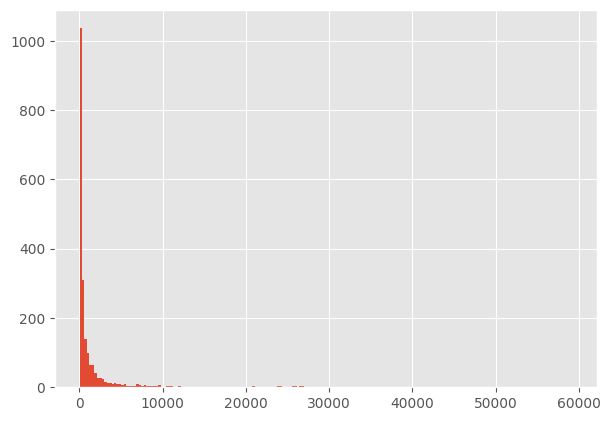

In [9]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (7,5), 'figure.dpi': 100})

n_bins = 200
hist_x, hist_y, hist_z = plt.hist(mins2tgt, bins=n_bins)

print(f"First 10 bins: {hist_x[:10]}")

In [10]:
print(f"Each bin represents around 60000/{n_bins} = {60000/n_bins} minutes = {60000/n_bins/60} hours of time,\n"
      f"which means {sum(hist_x[:1])/len(mins2tgt)*100:.1f}% of the time we reach +2% gain within {60000/n_bins/60} hours,\n"
      f"{sum(hist_x[:2])/len(mins2tgt)*100:.1f}% of the time within {2*60000/n_bins/60} hours, and so on.")


Each bin represents around 60000/200 = 300.0 minutes = 5.0 hours of time,
which means 50.1% of the time we reach +2% gain within 5.0 hours,
65.1% of the time within 10.0 hours, and so on.


In [12]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def normalise(df_orig):
    df = df_orig.copy()
    
    fields = list(df)
    
    for field in fields:
        if field in ['volume', 'trades']:
            for ma in [1, 3, 9]:
                df[f"{field}_pm_ma{ma}"] = df[field].rolling(window=ma).mean() / FREQ
        else:
            if field != 'close':
                df[f"{field}_norm"] = df[field] / df['close']

        if field != 'close':
            df.drop(field, axis=1, inplace=True)
    
    for x in [50, 200]:
        df[f"close_ma{x}_norm"] = df['close'].rolling(window=x).mean() / df['close']
    
    for x in [12, 26]:
        df[f"close_ema{x}_norm"] = ema(df['close'], x) / df['close']
    
    df.drop('close', axis=1, inplace=True)
    return df

df_n = normalise(df)
df_n

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm
2021-01-01 00:00:00,0.999896,1.000262,0.999388,91.8900,NaN,NaN,30.0,NaN,NaN,NaN,NaN,1.000000,1.000000
2021-01-01 00:01:00,0.999650,1.000922,0.999164,309.4800,NaN,NaN,53.0,NaN,NaN,NaN,NaN,0.999543,0.999500
2021-01-01 00:02:00,1.001281,1.001313,0.999243,591.9600,331.110000,NaN,56.0,46.333333,NaN,NaN,NaN,1.000502,1.000510
2021-01-01 00:03:00,1.001202,1.001202,1.000000,391.0600,430.833333,NaN,54.0,54.333333,NaN,NaN,NaN,1.001720,1.001889
2021-01-01 00:04:00,1.000179,1.000715,0.999587,216.2000,399.740000,NaN,49.0,53.000000,NaN,NaN,NaN,1.001646,1.001958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998772,1.000676,0.998434,175.7773,215.617600,295.126289,107.0,122.333333,151.888889,1.001310,1.010835,0.999641,1.000626
2021-05-31 00:57:00,0.998498,1.000521,0.998498,137.2728,160.450300,260.245622,127.0,111.333333,143.777778,0.999698,1.009088,0.998322,0.999074
2021-05-31 00:58:00,1.000245,1.000307,0.998651,92.0236,135.024567,234.063278,76.0,103.333333,136.111111,0.999543,1.008746,0.998373,0.998916
2021-05-31 00:59:00,1.000951,1.001166,0.999018,425.4814,218.259267,246.166967,102.0,101.666667,126.888889,1.000659,1.009697,0.999505,0.999961


In [13]:
from joblib import Parallel, delayed  

def compute_mins(i):
    t, y = minutes_to_target(df, i, target=TARGET)
    if y:
        return y
    else:
        return 120000

mins2tgt = Parallel(n_jobs=16)(delayed(compute_mins)(i) for i in tqdm(range(len(df))))

df_n['mins2tgt'] = mins2tgt

100%|█████████████████████████████████████████████████████████████████████████| 215398/215398 [05:36<00:00, 640.26it/s]


In [65]:
df.to_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-raw-{TARGET}.csv")
df_n.to_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-norm-{TARGET}.csv")

In [15]:
df_n.dropna(inplace=True)
df_n

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277,419
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653,419
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313,418
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932,417
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998772,1.000676,0.998434,175.7773,215.617600,295.126289,107.0,122.333333,151.888889,1.001310,1.010835,0.999641,1.000626,120000
2021-05-31 00:57:00,0.998498,1.000521,0.998498,137.2728,160.450300,260.245622,127.0,111.333333,143.777778,0.999698,1.009088,0.998322,0.999074,120000
2021-05-31 00:58:00,1.000245,1.000307,0.998651,92.0236,135.024567,234.063278,76.0,103.333333,136.111111,0.999543,1.008746,0.998373,0.998916,120000
2021-05-31 00:59:00,1.000951,1.001166,0.999018,425.4814,218.259267,246.166967,102.0,101.666667,126.888889,1.000659,1.009697,0.999505,0.999961,120000


In [21]:
df_n[df_n['mins2tgt'] == 120000].tail(100)

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-05-30 23:21:00,0.998001,1.000636,0.997880,146.0882,546.093467,286.075411,123.0,125.000000,118.555556,1.001579,1.004464,0.999403,0.999848,120000
2021-05-30 23:22:00,1.000242,1.001181,0.999788,111.5222,557.987800,288.135456,89.0,131.333333,118.777778,1.001492,1.004400,0.999469,0.999831,120000
2021-05-30 23:23:00,1.001213,1.001213,0.999303,123.4956,127.035333,269.543889,98.0,103.333333,113.222222,1.002646,1.005580,1.000577,1.000967,120000
2021-05-30 23:24:00,0.998426,1.000242,0.998426,106.9463,113.988033,263.462622,73.0,86.666667,106.444444,1.001067,1.004028,0.999206,0.999492,120000
2021-05-30 23:25:00,1.000879,1.000879,0.999849,43.9364,91.459433,263.384522,48.0,73.000000,103.222222,1.001867,1.004846,1.000046,1.000315,120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998772,1.000676,0.998434,175.7773,215.617600,295.126289,107.0,122.333333,151.888889,1.001310,1.010835,0.999641,1.000626,120000
2021-05-31 00:57:00,0.998498,1.000521,0.998498,137.2728,160.450300,260.245622,127.0,111.333333,143.777778,0.999698,1.009088,0.998322,0.999074,120000
2021-05-31 00:58:00,1.000245,1.000307,0.998651,92.0236,135.024567,234.063278,76.0,103.333333,136.111111,0.999543,1.008746,0.998373,0.998916,120000
2021-05-31 00:59:00,1.000951,1.001166,0.999018,425.4814,218.259267,246.166967,102.0,101.666667,126.888889,1.000659,1.009697,0.999505,0.999961,120000


In [3]:
signal_cat = ['VERY HIGH', 'HIGH', 'NORMAL', 'LOW', 'VERY LOW']
signal_thr = [0.2, 0.4, 0.6, 0.8, 1.0]

def find_quantiles(df_q):
    quantiles = []
    for c, q in zip(signal_cat, signal_thr):
        quantiles.append({'cat': c, 'quantile': q, 'value': df_q['mins2tgt'].quantile(q)})
    return quantiles

quantiles = find_quantiles(df_n)
quantiles

NameError: name 'df_n' is not defined

In [37]:
print(f"Everything higher than {quantiles[-2]['value']} will be treated as VERY LOW, therefore we can remove\n"
      f"the last rows within such interval.")

Everything higher than 1852.0 will be treated as VERY LOW, therefore we can remove
the last rows within such interval.


In [41]:
df_n[df_n.index >= df_n.index[-1]]

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-05-31 01:00:00,1.007296,1.007296,0.99932,1230.1234,582.5428,365.265444,762.0,313.333333,203.777778,1.007929,1.017054,1.005856,1.006833,120000


In [92]:
remove_after_this = df_n.index[-1] - timedelta(minutes=quantiles[-2]['value'])
df_ml = df_n[df_n.index < remove_after_this].copy()
df_ml

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277,419
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653,419
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313,418
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932,417
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29 18:03:00,1.000739,1.001863,0.998715,529.6373,566.792833,1124.440022,342.0,318.000000,463.888889,0.999423,1.006492,1.003394,1.002553,733
2021-05-29 18:04:00,1.000354,1.002766,0.998842,819.3472,590.358600,1007.748111,374.0,323.666667,391.777778,1.000623,1.007335,1.003663,1.003229,732
2021-05-29 18:05:00,1.002256,1.002482,0.999323,385.6909,578.225133,909.833222,323.0,346.333333,366.666667,1.003070,1.009476,1.005016,1.005086,731
2021-05-29 18:06:00,0.998262,1.000515,0.997779,637.0861,614.041400,840.844333,371.0,356.000000,358.333333,1.002084,1.008168,1.003259,1.003630,730


In [ ]:
df_ml.to_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-ml-{TARGET}.csv")

In [ ]:
# TODO: add categorical column + train model

A few data visualisations...

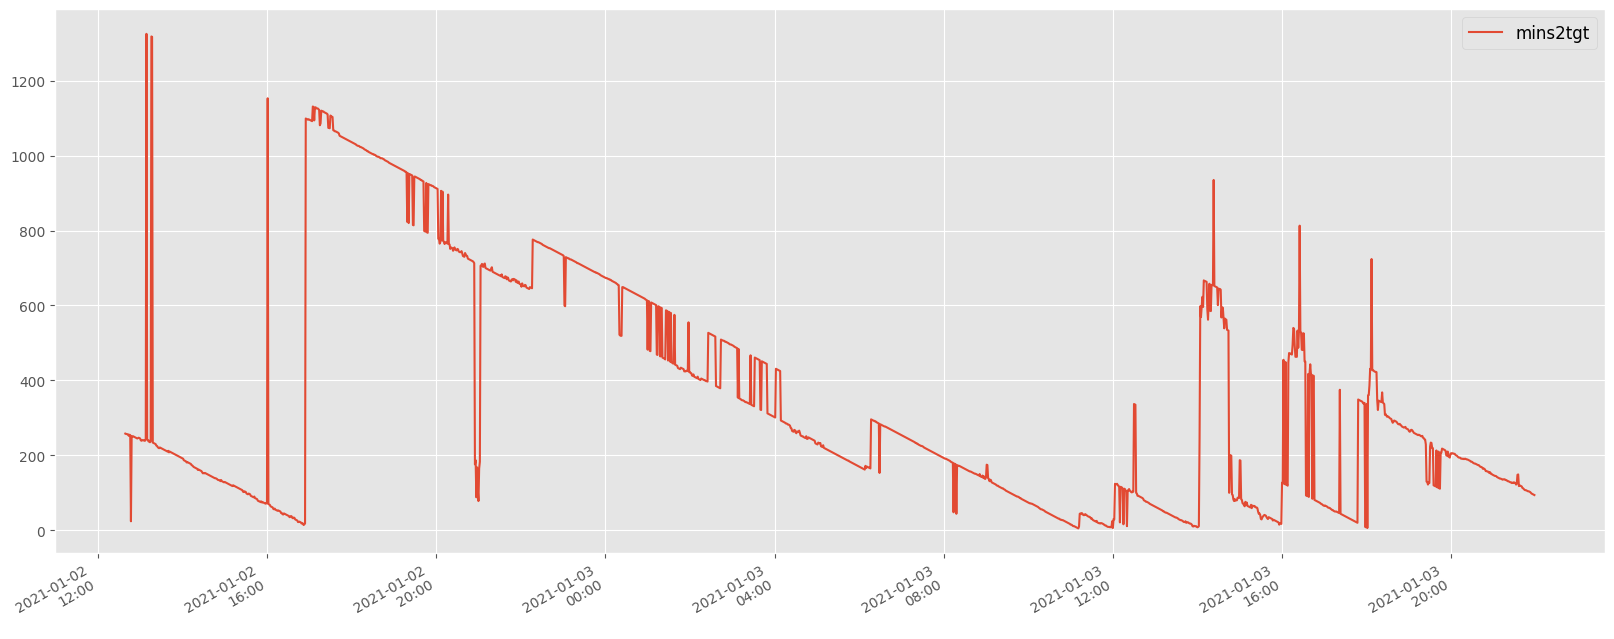

In [57]:
plot(plt.plot, df_n.iloc[2000:4000], ['mins2tgt'])

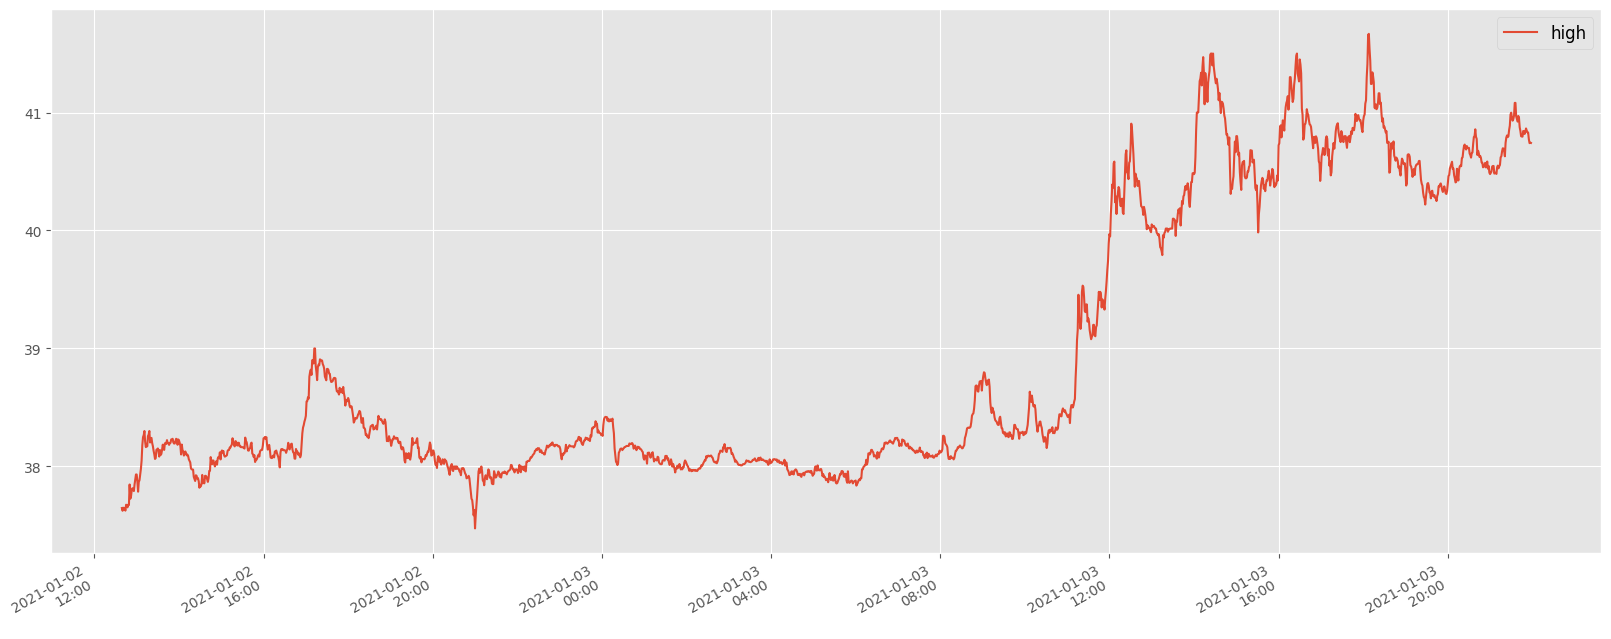

In [64]:
plot(plt.plot, df.dropna().iloc[2000:4000], ['high'])

In [89]:
p = 3009
print(df.dropna().iloc[p])

print(f"\ntarget: {df.dropna().iloc[p]['close'] * 1.02}")

df[df.index == df.dropna().index[p] + timedelta(minutes=df.dropna().iloc[p]['mins2tgt'])]

open         37.8770
high         37.8791
low          37.8570
close        37.8791
volume      289.4900
trades       32.0000
mins2tgt    202.0000
Name: 2021-01-03 05:28:00, dtype: float64

target: 38.636682


,open,high,low,close,volume,trades,mins2tgt
2021-01-03 08:50:00,38.56,38.68,38.56,38.6714,1448.36,202,146.0


In [58]:
df['mins2tgt'] = df_n['mins2tgt']

In [90]:
df_n

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277,419
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653,419
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313,418
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932,417
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998772,1.000676,0.998434,175.7773,215.617600,295.126289,107.0,122.333333,151.888889,1.001310,1.010835,0.999641,1.000626,120000
2021-05-31 00:57:00,0.998498,1.000521,0.998498,137.2728,160.450300,260.245622,127.0,111.333333,143.777778,0.999698,1.009088,0.998322,0.999074,120000
2021-05-31 00:58:00,1.000245,1.000307,0.998651,92.0236,135.024567,234.063278,76.0,103.333333,136.111111,0.999543,1.008746,0.998373,0.998916,120000
2021-05-31 00:59:00,1.000951,1.001166,0.999018,425.4814,218.259267,246.166967,102.0,101.666667,126.888889,1.000659,1.009697,0.999505,0.999961,120000


## Load from file

In [4]:
import pandas as pd

SYMBOL = 'BNBBUSD'
FREQ = 1
START = '20210101000000'
TARGET = 1.02
DAYS = 150

df_ml = pd.read_csv(f"{SYMBOL}-{START}-{FREQ}-{DAYS}-probabilistic-ml-{TARGET}.csv").set_index('Unnamed: 0')
df_ml = df_ml.set_index(pd.to_datetime(df_ml.index))
df_ml

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
Unnamed: 0,,,,,,,,,,,,,,
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277,419
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653,419
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313,418
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932,417
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29 18:03:00,1.000739,1.001863,0.998715,529.6373,566.792833,1124.440022,342.0,318.000000,463.888889,0.999423,1.006492,1.003394,1.002553,733
2021-05-29 18:04:00,1.000354,1.002766,0.998842,819.3472,590.358600,1007.748111,374.0,323.666667,391.777778,1.000623,1.007335,1.003663,1.003229,732
2021-05-29 18:05:00,1.002256,1.002482,0.999323,385.6909,578.225133,909.833222,323.0,346.333333,366.666667,1.003070,1.009476,1.005016,1.005086,731


In [5]:
signal_cat = ['VERY HIGH', 'HIGH', 'NORMAL', 'LOW', 'VERY LOW']
signal_thr = [0.2, 0.4, 0.6, 0.8, 1.0]

def find_quantiles(df_q):
    quantiles = []
    for c, q in zip(signal_cat, signal_thr):
        quantiles.append({'cat': c, 'quantile': q, 'value': df_q['mins2tgt'].quantile(q)})
    return quantiles

quantiles = find_quantiles(df_ml)
quantiles

[{'cat': 'VERY HIGH', 'quantile': 0.2, 'value': 76.0},
 {'cat': 'HIGH', 'quantile': 0.4, 'value': 212.0},
 {'cat': 'NORMAL', 'quantile': 0.6, 'value': 534.0},
 {'cat': 'LOW', 'quantile': 0.8, 'value': 1836.0},
 {'cat': 'VERY LOW', 'quantile': 1.0, 'value': 120000.0}]

In [6]:
df_ml['cat'] = None

def to_cat(x):
    for q in reversed(quantiles):
        if x <= q['value']:
            res = q['cat']
    return res

df_ml['cat'] = df_ml['mins2tgt'].map(to_cat)
df_ml

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt,cat
Unnamed: 0,,,,,,,,,,,,,,,
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277,419,NORMAL
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653,419,NORMAL
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313,418,NORMAL
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932,417,NORMAL
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767,415,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29 18:03:00,1.000739,1.001863,0.998715,529.6373,566.792833,1124.440022,342.0,318.000000,463.888889,0.999423,1.006492,1.003394,1.002553,733,LOW
2021-05-29 18:04:00,1.000354,1.002766,0.998842,819.3472,590.358600,1007.748111,374.0,323.666667,391.777778,1.000623,1.007335,1.003663,1.003229,732,LOW
2021-05-29 18:05:00,1.002256,1.002482,0.999323,385.6909,578.225133,909.833222,323.0,346.333333,366.666667,1.003070,1.009476,1.005016,1.005086,731,LOW


In [7]:
str(list(df_ml.columns))

"['open_norm', 'high_norm', 'low_norm', 'volume_pm_ma1', 'volume_pm_ma3', 'volume_pm_ma9', 'trades_pm_ma1', 'trades_pm_ma3', 'trades_pm_ma9', 'close_ma50_norm', 'close_ma200_norm', 'close_ema12_norm', 'close_ema26_norm', 'mins2tgt', 'cat']"

In [8]:
feat_cols = ['open_norm', 'high_norm', 'low_norm', 'volume_pm_ma1', 'volume_pm_ma3', 
             'volume_pm_ma9', 'trades_pm_ma1', 'trades_pm_ma3', 'trades_pm_ma9', 
             'close_ma50_norm', 'close_ma200_norm', 'close_ema12_norm', 'close_ema26_norm']
df_ml_feats = df_ml[feat_cols]

## Dimensionality reduction and visualisation

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 213346 samples in 0.793s...
[t-SNE] Computed neighbors for 213346 samples in 20.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 213346
[t-SNE] Computed conditional probabilities for sample 2000 / 213346
[t-SNE] Computed conditional probabilities for sample 3000 / 213346
[t-SNE] Computed conditional probabilities for sample 4000 / 213346
[t-SNE] Computed conditional probabilities for sample 5000 / 213346
[t-SNE] Computed conditional probabilities for sample 6000 / 213346
[t-SNE] Computed conditional probabilities for sample 7000 / 213346
[t-SNE] Computed conditional probabilities for sample 8000 / 213346
[t-SNE] Computed conditional probabilities for sample 9000 / 213346
[t-SNE] Computed conditional probabilities for sample 10000 / 213346
[t-SNE] Computed conditional probabilities for sample 11000 / 213346
[t-SNE] Computed conditional probabilities for sample 12000 / 213346
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 121000 / 213346
[t-SNE] Computed conditional probabilities for sample 122000 / 213346
[t-SNE] Computed conditional probabilities for sample 123000 / 213346
[t-SNE] Computed conditional probabilities for sample 124000 / 213346
[t-SNE] Computed conditional probabilities for sample 125000 / 213346
[t-SNE] Computed conditional probabilities for sample 126000 / 213346
[t-SNE] Computed conditional probabilities for sample 127000 / 213346
[t-SNE] Computed conditional probabilities for sample 128000 / 213346
[t-SNE] Computed conditional probabilities for sample 129000 / 213346
[t-SNE] Computed conditional probabilities for sample 130000 / 213346
[t-SNE] Computed conditional probabilities for sample 131000 / 213346
[t-SNE] Computed conditional probabilities for sample 132000 / 213346
[t-SNE] Computed conditional probabilities for sample 133000 / 213346
[t-SNE] Computed conditional probabilities for sample 134000 / 213346
[t-SNE] Computed con

No handles with labels found to put in legend.


[t-SNE] KL divergence after 250 iterations: 6.097409


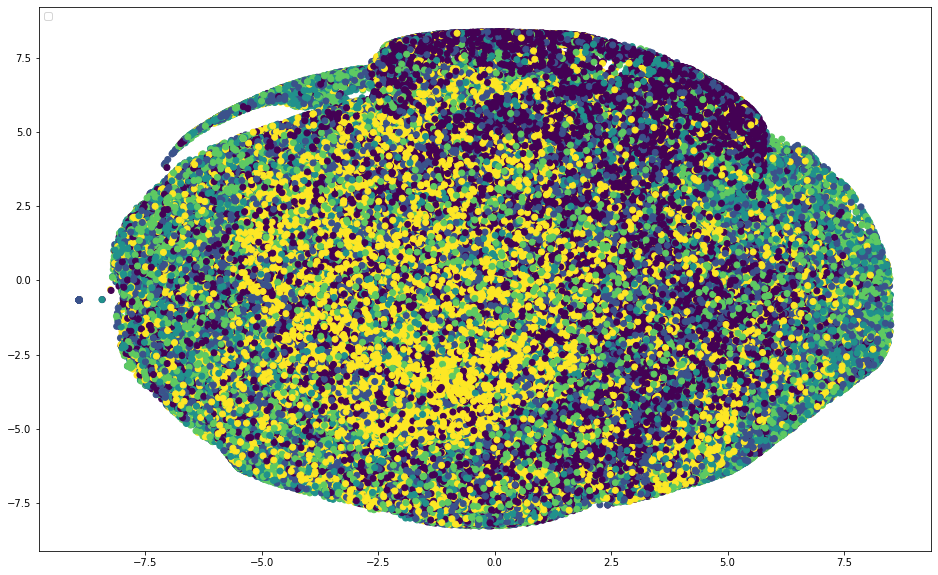

In [107]:
# apply dimensionality reduction

# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# dimred_result = pca.fit_transform(df_ml_feats)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
dimred_result = tsne.fit_transform(df_ml_feats)

import numpy as np
import math
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))

to_colour = {}
for q in quantiles:
    to_colour[q['cat']] = len(to_colour)

colours = [to_colour[x] for x in list(df_ml['cat'])]

plt.scatter(dimred_result[:,0], dimred_result[:,1], c=colours)
plt.legend(loc="upper left")

In [12]:
len(df_ml_feats)

213346

## Multiclass model training

In [96]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

TRAINING_SIZE = 100000

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(df_ml_feats[:TRAINING_SIZE], df_ml['cat'][:TRAINING_SIZE])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [98]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate():
    # evaluate on last N examples
    N = 20000
    labels = list(reversed(signal_cat))
    test = df_ml_feats.tail(N)
    actual = df_ml['cat'].tail(N)
    pred = clf.predict(test)
    cm = confusion_matrix(actual, pred, labels=labels)
    prf = precision_recall_fscore_support(actual, pred, labels=labels)
    print(f"{cm}\n")
    T = 10
    print("          \t" + "\t".join(labels).expandtabs(T))
    print("Precision:\t" + "\t".join([f"{x:.3f}" for x in prf[0]]).expandtabs(T))
    print("Recall:   \t" + "\t".join([f"{x:.3f}" for x in prf[1]]).expandtabs(T))
    print("F-Score:  \t" + "\t".join([f"{x:.3f}" for x in prf[2]]).expandtabs(T))

evaluate()

[[2925  167  385  809 1336]
 [ 658   22   50  261  772]
 [ 656   36   51  153  819]
 [1281   44  128  265 1692]
 [1866   45   73  375 5131]]

          	VERY LOW  LOW       NORMAL    HIGH      VERY HIGH
Precision:	0.396     0.070     0.074     0.142     0.526
Recall:   	0.520     0.012     0.030     0.078     0.685
F-Score:  	0.450     0.021     0.042     0.101     0.595


In [99]:
df_ml_feats

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm
0,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277
1,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653
2,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313
3,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932
4,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213341,1.000739,1.001863,0.998715,529.6373,566.792833,1124.440022,342.0,318.000000,463.888889,0.999423,1.006492,1.003394,1.002553
213342,1.000354,1.002766,0.998842,819.3472,590.358600,1007.748111,374.0,323.666667,391.777778,1.000623,1.007335,1.003663,1.003229
213343,1.002256,1.002482,0.999323,385.6909,578.225133,909.833222,323.0,346.333333,366.666667,1.003070,1.009476,1.005016,1.005086
213344,0.998262,1.000515,0.997779,637.0861,614.041400,840.844333,371.0,356.000000,358.333333,1.002084,1.008168,1.003259,1.003630


In [152]:
df_ml

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt,cat
Unnamed: 0,,,,,,,,,,,,,,,
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277,419,NORMAL
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653,419,NORMAL
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313,418,NORMAL
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932,417,NORMAL
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767,415,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29 18:03:00,1.000739,1.001863,0.998715,529.6373,566.792833,1124.440022,342.0,318.000000,463.888889,0.999423,1.006492,1.003394,1.002553,733,LOW
2021-05-29 18:04:00,1.000354,1.002766,0.998842,819.3472,590.358600,1007.748111,374.0,323.666667,391.777778,1.000623,1.007335,1.003663,1.003229,732,LOW
2021-05-29 18:05:00,1.002256,1.002482,0.999323,385.6909,578.225133,909.833222,323.0,346.333333,366.666667,1.003070,1.009476,1.005016,1.005086,731,LOW


In [153]:
df_plot

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm,mins2tgt
Unnamed: 0,,,,,,,,,,,,,,
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277,419
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653,419
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313,418
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932,417
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29 18:03:00,1.000739,1.001863,0.998715,529.6373,566.792833,1124.440022,342.0,318.000000,463.888889,0.999423,1.006492,1.003394,1.002553,733
2021-05-29 18:04:00,1.000354,1.002766,0.998842,819.3472,590.358600,1007.748111,374.0,323.666667,391.777778,1.000623,1.007335,1.003663,1.003229,732
2021-05-29 18:05:00,1.002256,1.002482,0.999323,385.6909,578.225133,909.833222,323.0,346.333333,366.666667,1.003070,1.009476,1.005016,1.005086,731


## Signal detection

Each dot is a moment between Jan 1st and June 1st this year. The blue dots are moments with a high buy signal where the price went +2% in less than 30 hours (`VERY HIGH`, `HIGH`, `NORMAL`, and `LOW` categories). My aim is to detect them automatically.

In [9]:
# filter out y=120k (which means 'never reaches +2%') and y>40k (exceptionally bad points)
# df_plot = df_ml[df_ml['mins2tgt'] < 40000].copy()
df_plot = df_ml.copy()

good_signals = ['VERY HIGH', 'HIGH', 'NORMAL', 'LOW']

open_norm


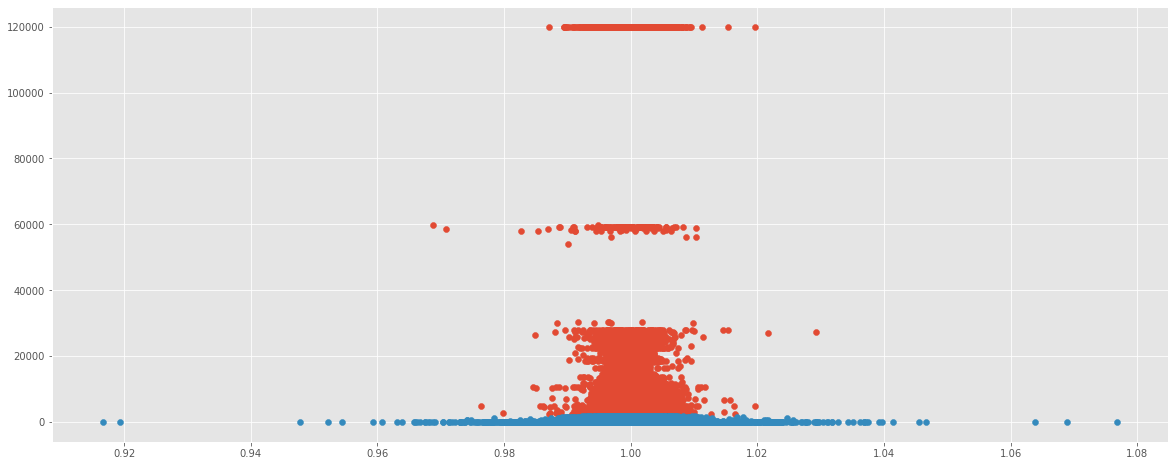

high_norm


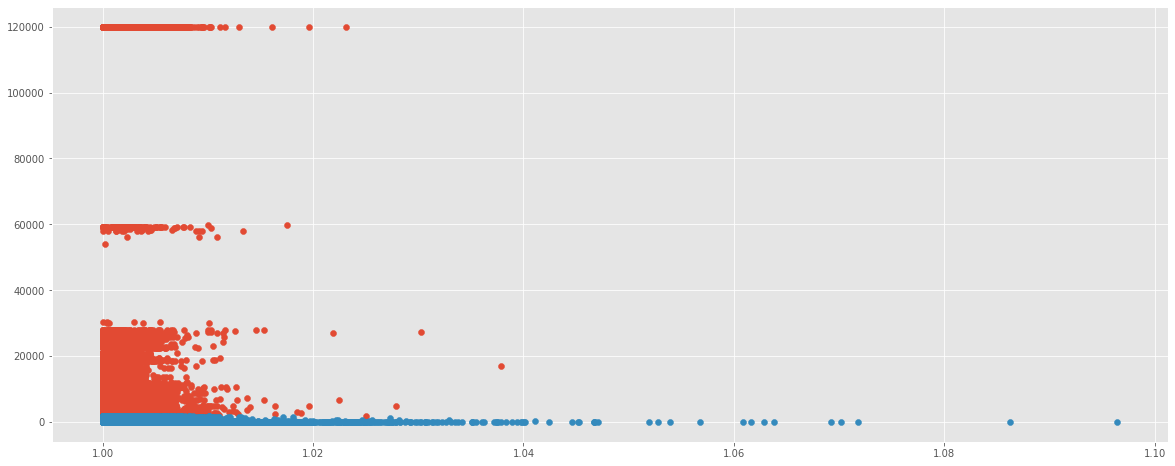

low_norm


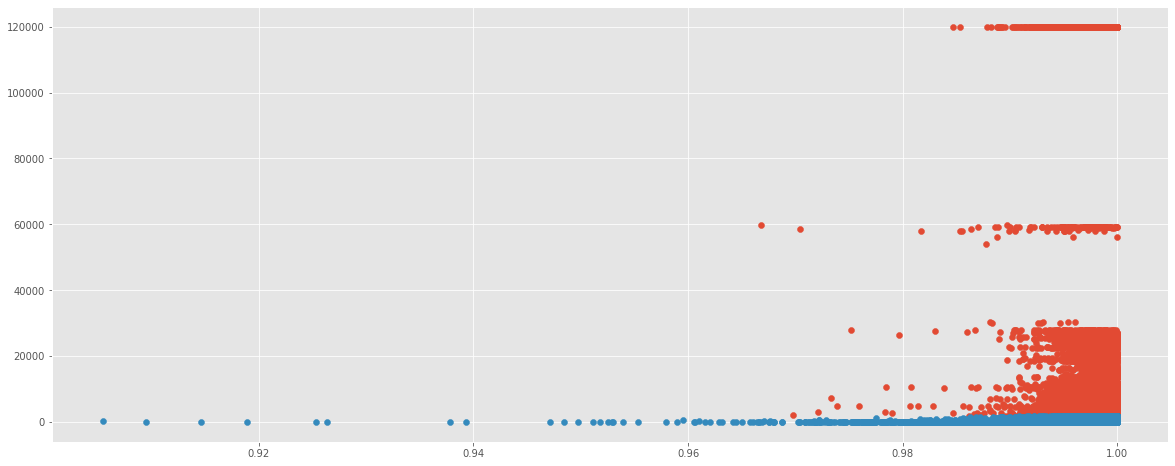

volume_pm_ma1


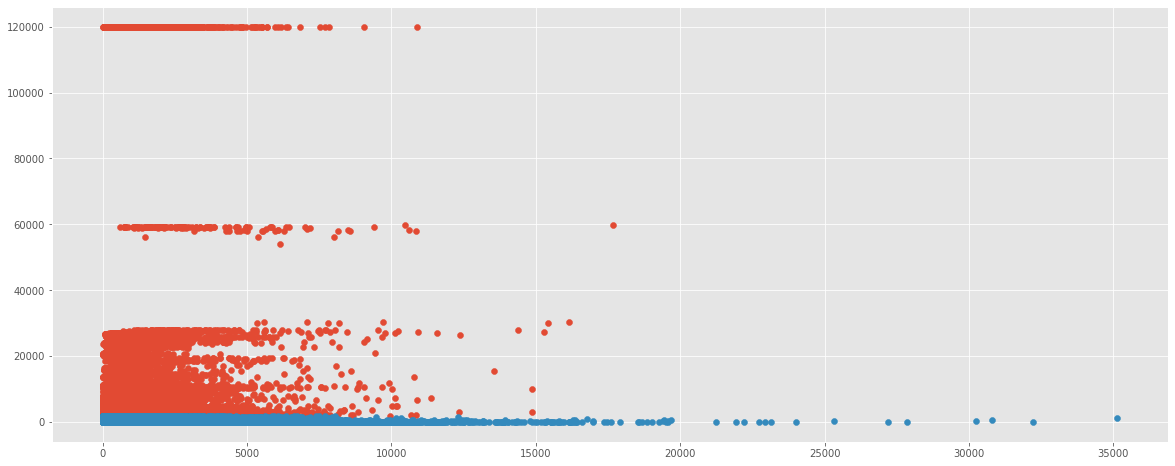

volume_pm_ma3


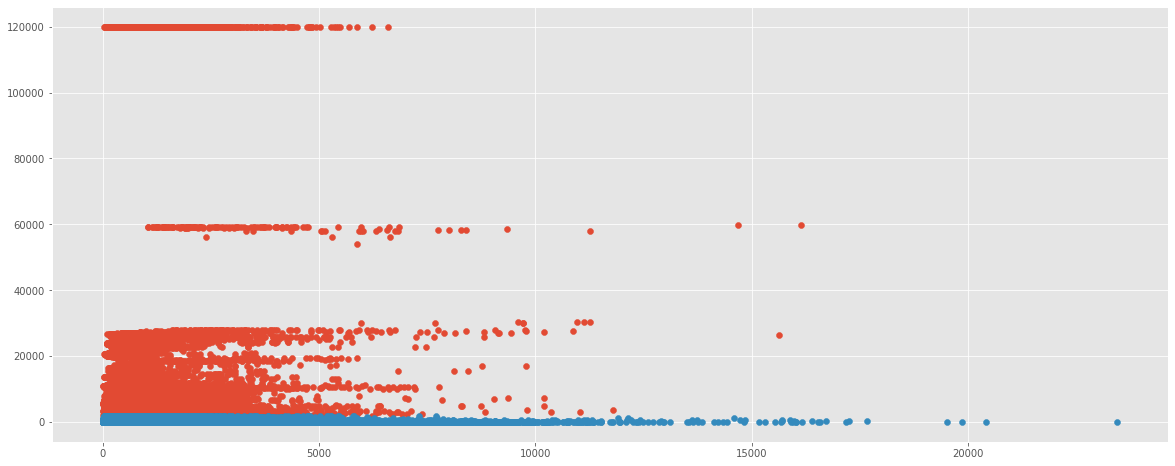

volume_pm_ma9


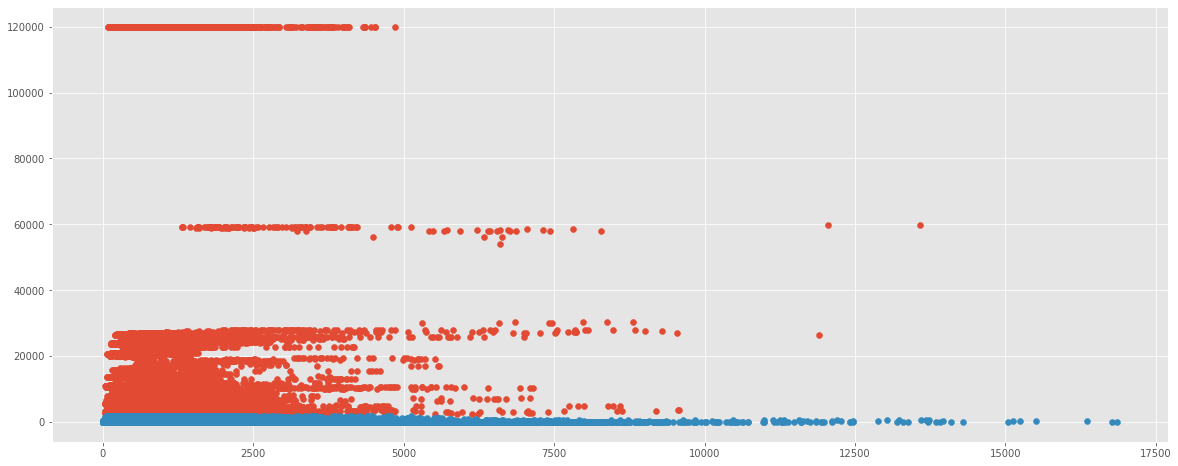

trades_pm_ma1


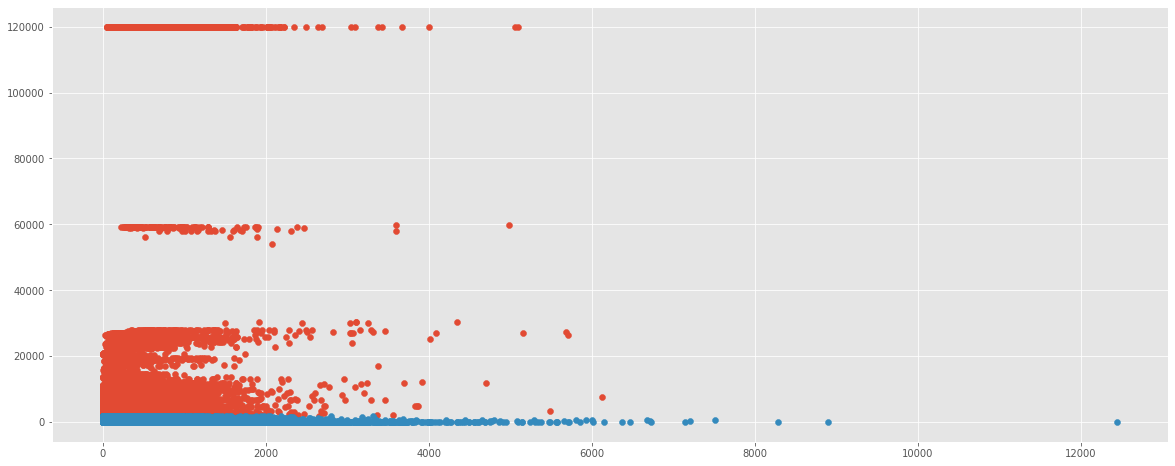

trades_pm_ma3


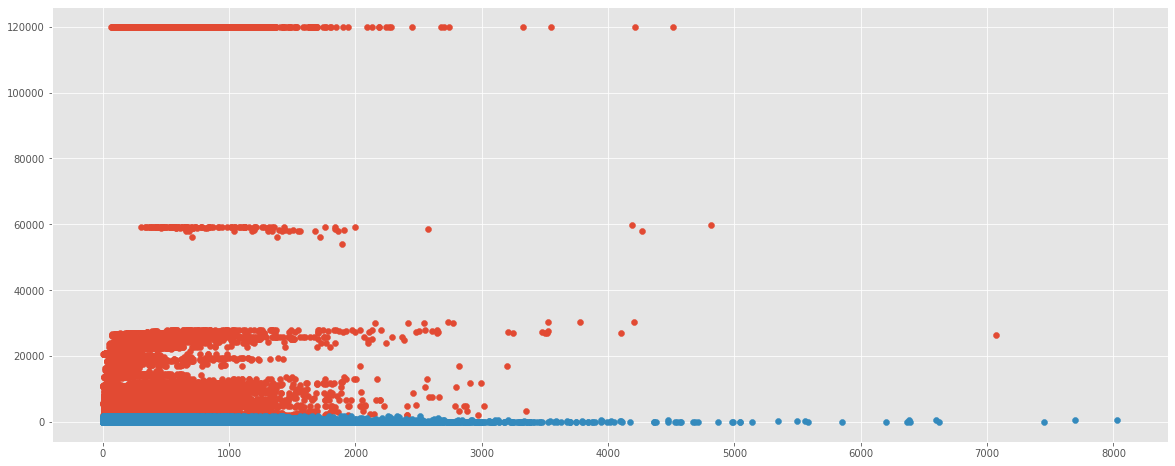

trades_pm_ma9


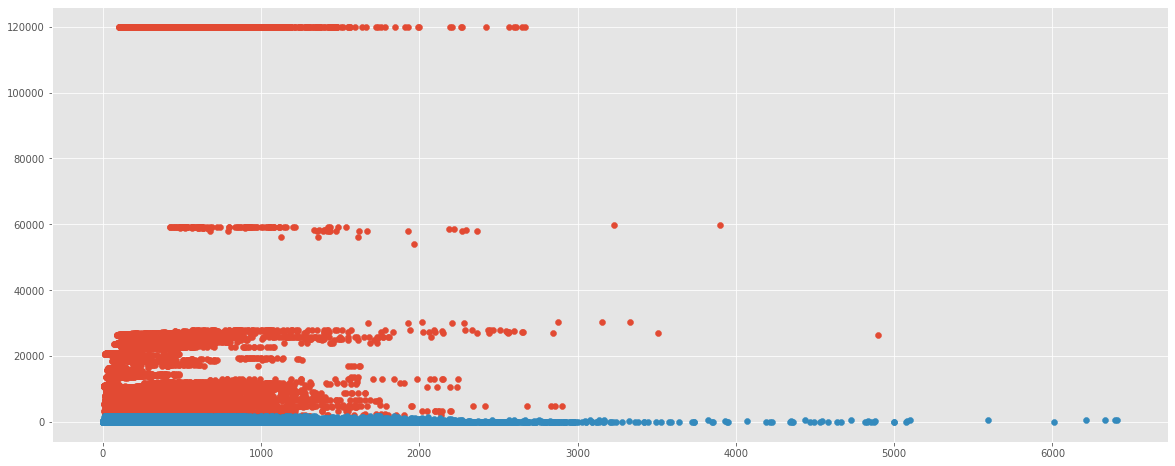

close_ma50_norm


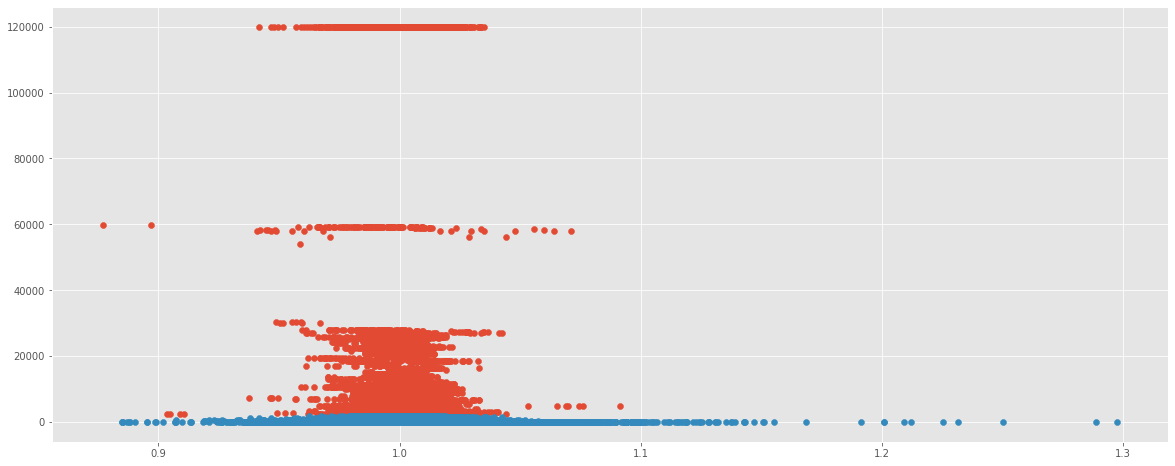

close_ma200_norm


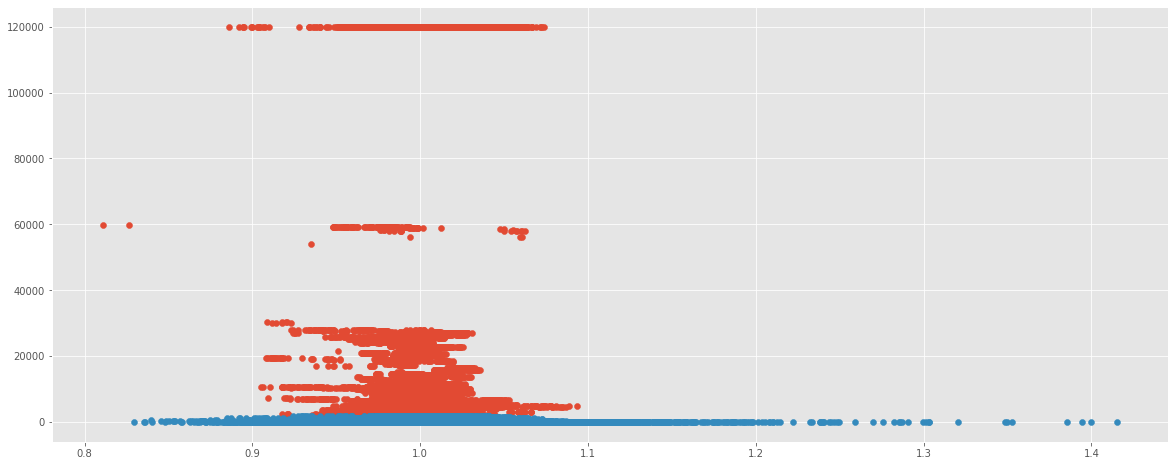

close_ema12_norm


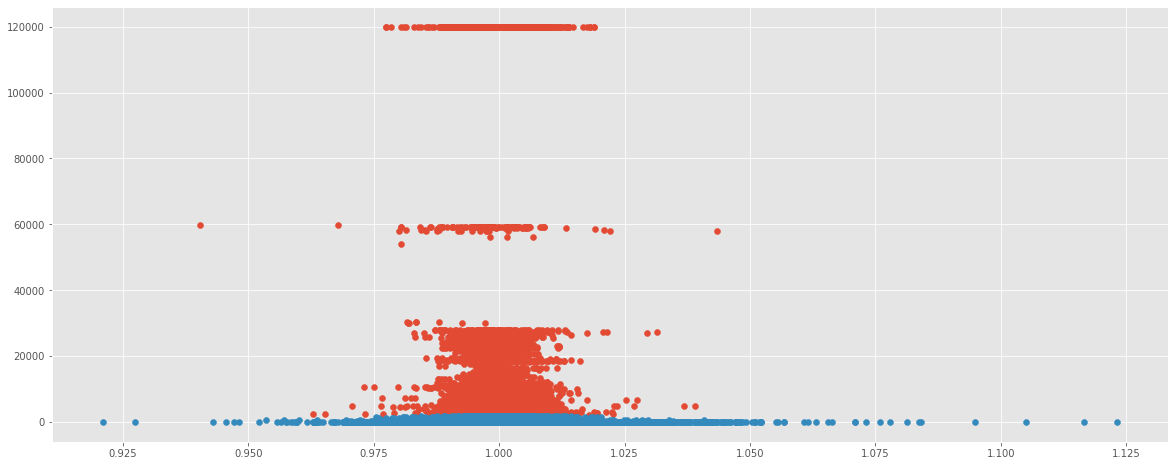

close_ema26_norm


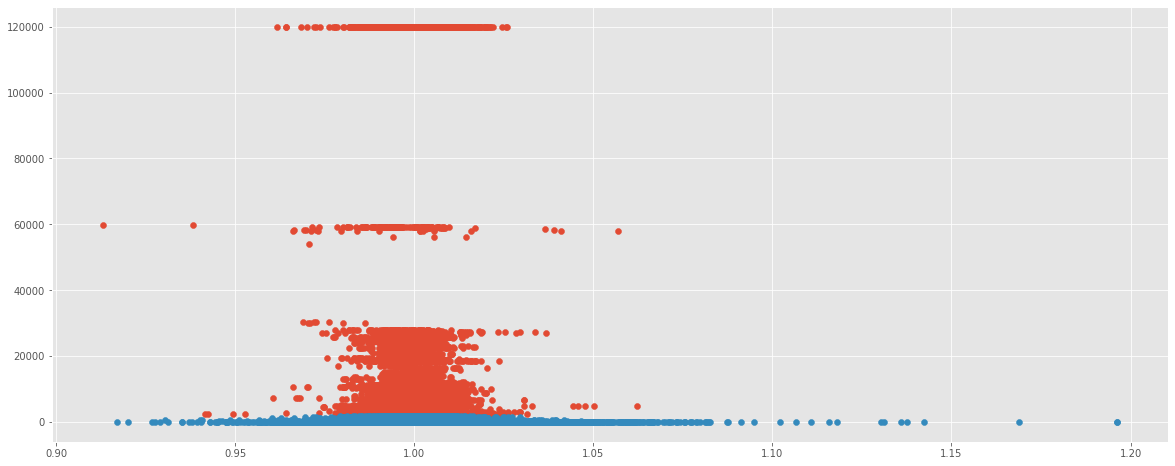

In [101]:
for fc in feat_cols:
    print(fc)
    # red dots = idle signals
    plt.scatter(df_plot[~df_plot['cat'].isin(good_signals)][fc], 
                df_plot[~df_plot['cat'].isin(good_signals)]['mins2tgt'])
    # blue dots = buy signals
    plt.scatter(df_plot[df_plot['cat'].isin(good_signals)][fc], 
                df_plot[df_plot['cat'].isin(good_signals)]['mins2tgt'])
    plt.show()

Check what happened right before the rightmost blue moments in the chart.

open        300.4000
high        301.0000
low         280.0000
close       289.7400
volume    11248.8087
trades     3334.0000
Name: 2021-05-19 13:54:00, dtype: float64



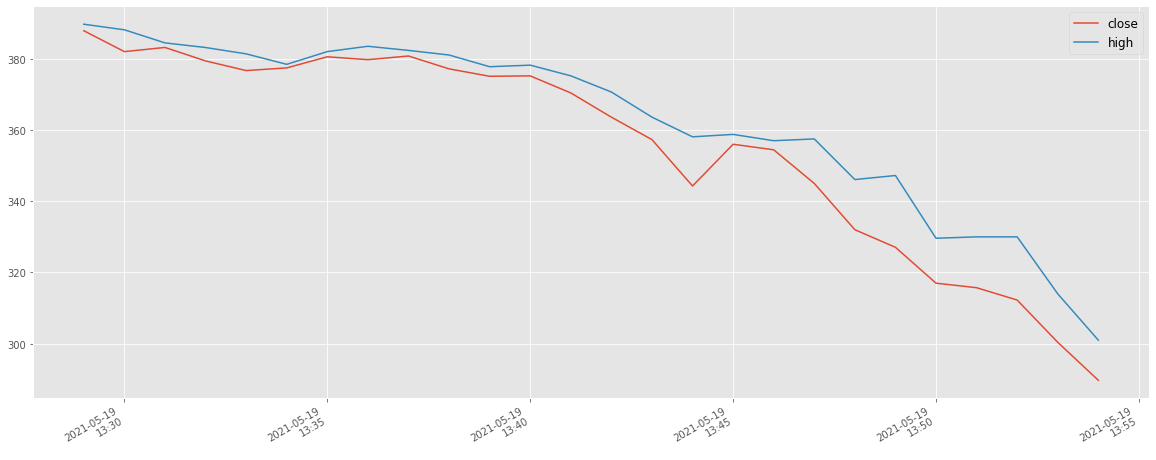

open       288.9900
high       293.8700
low        281.7900
close      286.0000
volume    9662.7017
trades    2844.0000
Name: 2021-05-19 13:55:00, dtype: float64



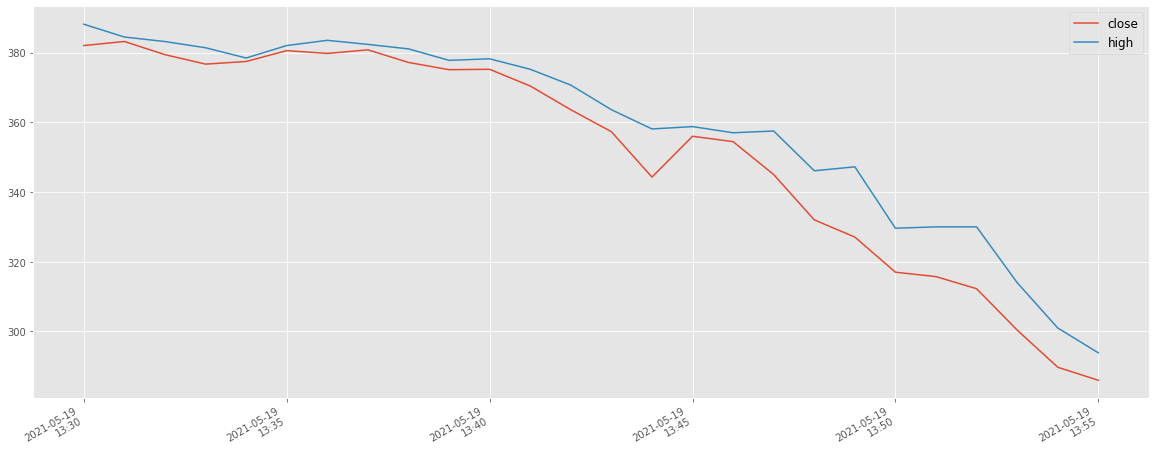

In [102]:
for t0 in df_ml[df_ml['close_ema26_norm'] > 1.19].index:
    print(f"{df.loc[t0]}\n")
    plot(plt.plot, df[df.index <= t0].tail(26), ['close', 'high'])
    plt.show()

## Threshold study

In [10]:
# relevants = len(df_ml['cat'].isin(good_signals))

def threshold_study(field, val_min, val_max, target):
    thrs = np.arange(val_min, val_max, 0.005)
    precs = []
    for thr in thrs:
        goods = len(df_ml[(df_ml[field] >= thr) & (df_ml['cat'].isin(good_signals))])
        bads = len(df_ml[(df_ml[field] >= thr) & (~df_ml['cat'].isin(good_signals))])
        prec = goods / (goods + bads) if goods + bads > 0 else 0
#         rec = goods / relevants
        precs.append(prec if target == 'p' else goods / DAYS)
    
    plt.plot(thrs, precs, label=field)
    if target == 's':
        plt.yscale('log')

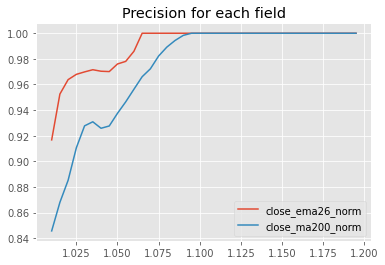

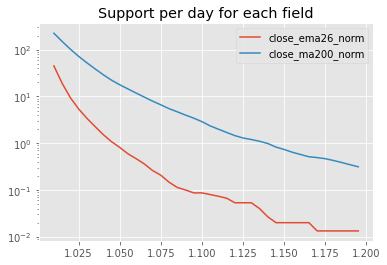

In [11]:
threshold_study('close_ema26_norm', 1.01, 1.2, 'p')
threshold_study('close_ma200_norm', 1.01, 1.2, 'p')
plt.legend(loc="best")
plt.title(f"Precision for each field")
plt.show()

threshold_study('close_ema26_norm', 1.01, 1.2, 's')
threshold_study('close_ma200_norm', 1.01, 1.2, 's')
plt.legend(loc="best")
plt.title(f"Support per day for each field")
plt.show()

## Binary model training

In [13]:
df_ml_feats_subset = df_ml_feats[['close_ema26_norm', 'close_ma200_norm']].copy()
df_ml_feats_binary = pd.DataFrame(df_ml['cat'].isin(good_signals))

In [118]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

N = 100000
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(df_ml_feats_subset.head(N), df_ml_feats_binary.head(N))

c:\users\agando\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

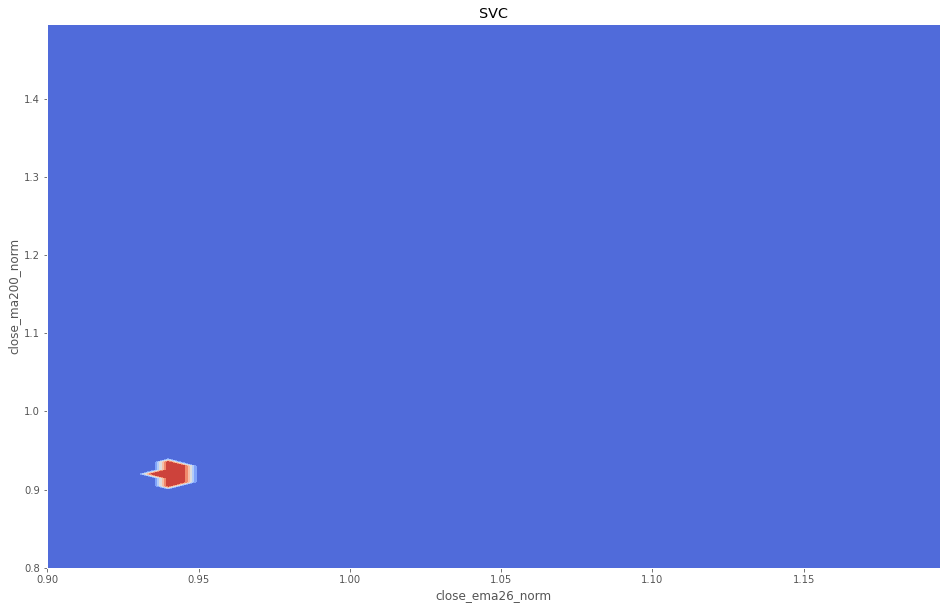

In [119]:
x_min, x_max = 0.9, 1.2
y_min, y_max = 0.8, 1.5
h = .005  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(16,10))
plt.contourf(xx, yy, 1-Z, cmap=plt.cm.coolwarm)

#     # Plot also the training points
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('close_ema26_norm')
plt.ylabel('close_ma200_norm')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('SVC')

plt.show()

Evaluating precision...: 213346it [00:22, 9338.91it/s]


{'pre': 0.9482124079915878, 'tp': 3607, 'fp': 197, 'tp/day': 24.046666666666667}
Unique days with prospect of +2%: 93
Total predicted change: +503.2%


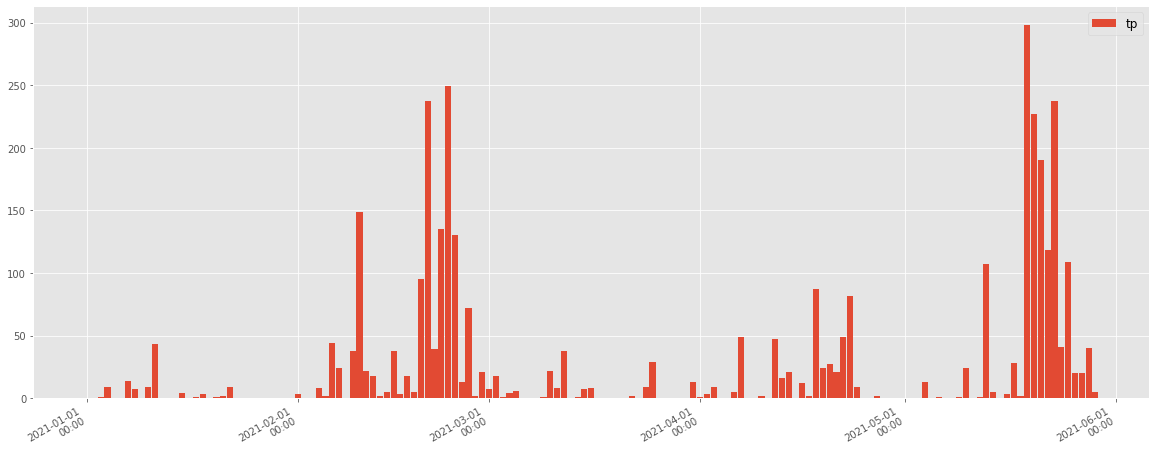

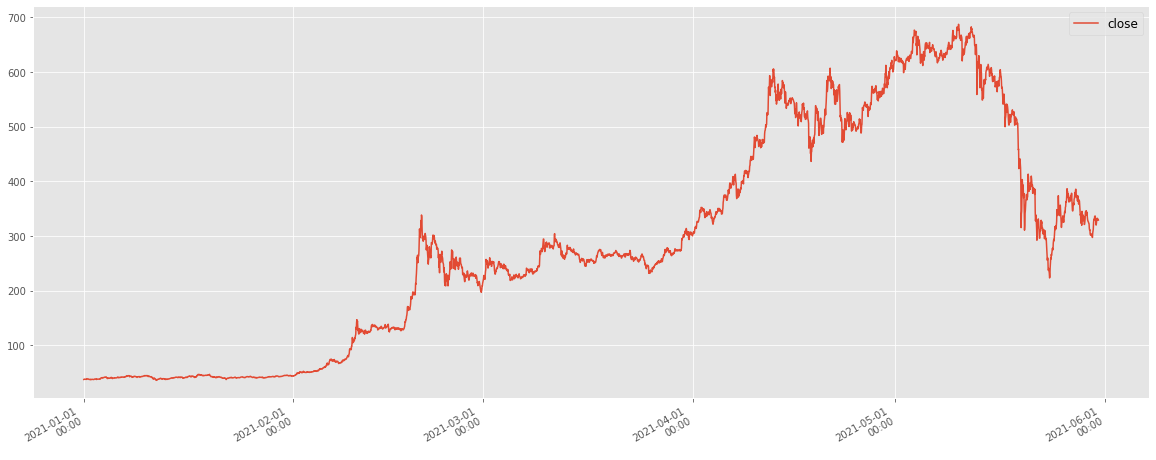

In [368]:
from collections import Counter

thr_x, thr_y = 1.015, 1.060

tp, fp = 0, 0

true_positive = []

for (_, X), (_, y) in tqdm(zip(df_ml_feats_subset.iterrows(), df_ml_feats_binary.iterrows()), desc='Evaluating precision...', ncols=100):
#     print(X['close_ema26_norm'], X['close_ma200_norm'], y['cat'])
    if X['close_ema26_norm'] >= thr_x or X['close_ma200_norm'] >= thr_y:
        if y['cat']:
            tp += 1
            true_positive.append(True)
        else:
            fp += 1
            true_positive.append(False)
    else:
        true_positive.append(False)

df_ml_feats_subset['tp'] = true_positive
df_tp = df_ml_feats_subset[df_ml_feats_subset['tp'] == True].copy()
df_tp['date'] = pd.to_datetime(df_tp.index)

evaluation = {'pre': tp/(tp+fp), 'tp': tp, 'fp': fp, 'tp/day': tp/DAYS}

print(evaluation)

c = Counter()

for i, row in df_tp.iterrows():
    c[(row['date'].year, row['date'].month, row['date'].day)] += 1

print(f"Unique days with prospect of +2%: {len(c)}")
print(f"Total predicted change: {(1.02 ** len(c) - 1) * evaluation['pre']:+.1%}")

start = pd.to_datetime(df_ml_feats_subset.index[0])
end = pd.to_datetime(df_ml_feats_subset.index[-1])

t = start
datedist = []

while True:
    datedist.append({'date': datetime(t.year, t.month, t.day), 'tp': c[(t.year, t.month, t.day)]})
    t = t + timedelta(days=1)
    if t >= end:
        break

df_datedist = pd.DataFrame.from_records(datedist, index='date')

plot(plt.bar, df_datedist, ['tp'], bar_size=.9)
plt.show()

plot(plt.plot, df[::60], ['close'])

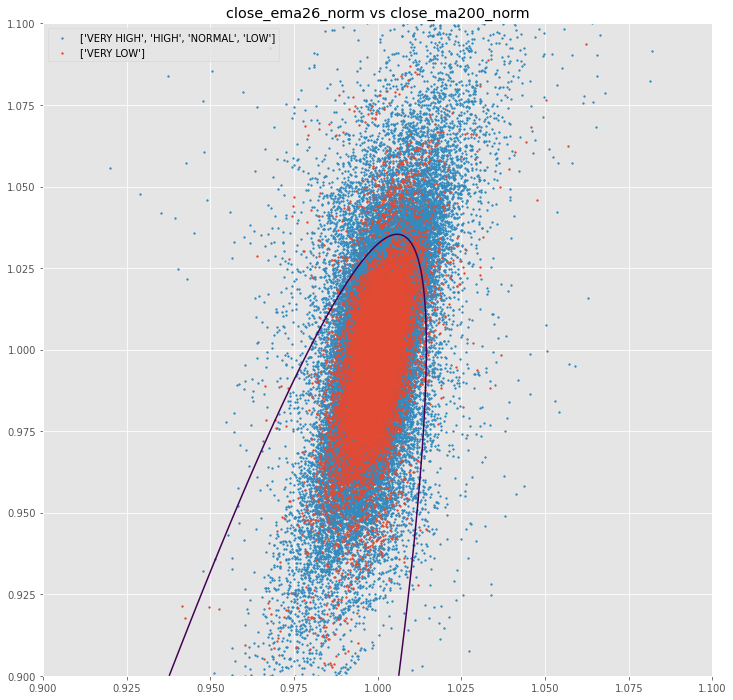

In [328]:
def is_good_signal(X, Y, decfun=False):
    Tx = -0.809
    Ty = -0.234
    F = (12*(X+Tx) - 3*(Y+Ty))**2 + (X+Tx) + (Y+Ty) - 1
    return F if decfun else F >= 0

plt.figure(figsize=(12, 12))

bad_signals = ['VERY LOW']

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  
to_col = {1: good_signals, 0: bad_signals}

delta = 0.001
xy_min, xy_max = 0.9, 1.1
xrange = np.arange(xy_min, xy_max, delta)
yrange = np.arange(xy_min, xy_max, delta)
X, Y = np.meshgrid(xrange,yrange)
F = is_good_signal(X, Y, decfun=True)
plt.contour(X, Y, F, [0])

for c, cl in to_col.items():
    selection = df_ml['cat'].isin(cl)
    plt.scatter(df_ml_feats[selection]['close_ema26_norm'], 
                df_ml_feats[selection]['close_ma200_norm'], 
                s=3, c=palette[c], label=cl)

plt.legend(loc="upper left")
plt.title("close_ema26_norm vs close_ma200_norm")
plt.gca().set_xlim([xy_min, xy_max])
plt.gca().set_ylim([xy_min, xy_max])
plt.show()

Evaluating precision...: 213346it [00:22, 9298.66it/s]


{'pre': 0.9270246860112603, 'tp': 8562, 'fp': 674, 'tp/day': 57.08}
Unique days with prospect of +2%: 107
Total predicted change: +678.8%


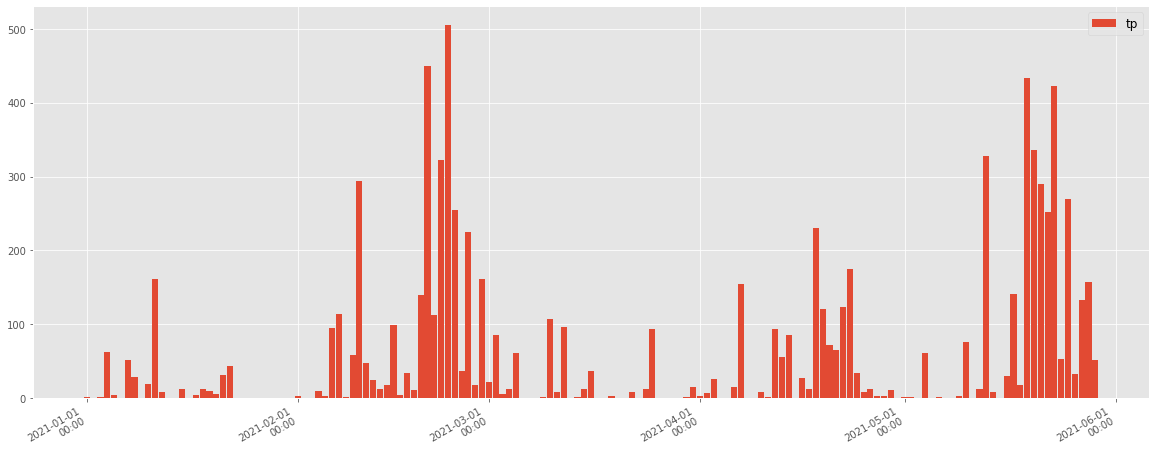

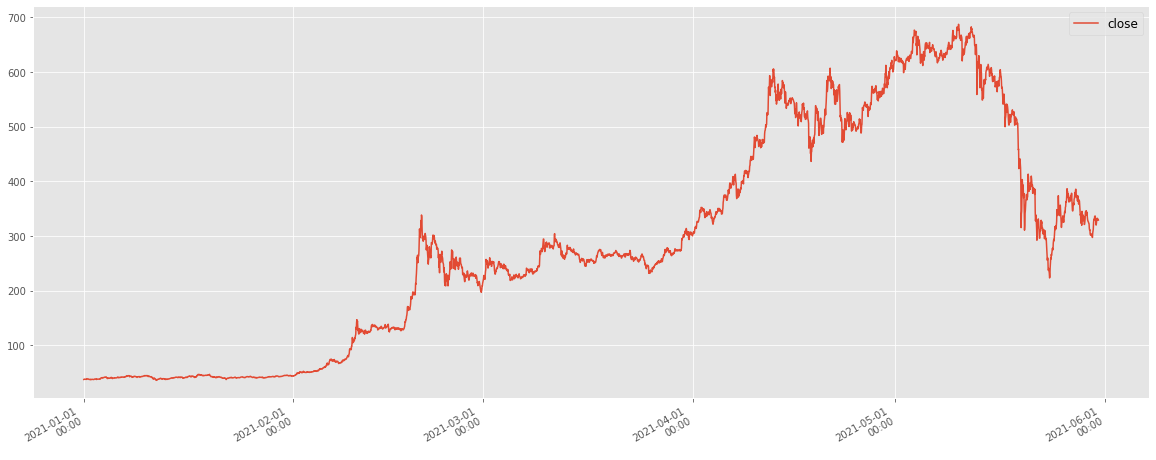

In [329]:
tp, fp = 0, 0

true_positive = []

for (_, X), (_, y) in tqdm(zip(df_ml_feats_subset.iterrows(), df_ml_feats_binary.iterrows()), 
                           desc='Evaluating precision...', ncols=100):
#     print(X['close_ema26_norm'], X['close_ma200_norm'], y['cat'])
    if is_good_signal(X['close_ema26_norm'], X['close_ma200_norm']):
        if y['cat']:
            tp += 1
            true_positive.append(True)
        else:
            fp += 1
            true_positive.append(False)
    else:
        true_positive.append(False)

df_ml_feats_subset['tp'] = true_positive
df_tp = df_ml_feats_subset[df_ml_feats_subset['tp'] == True].copy()
df_tp['date'] = pd.to_datetime(df_tp.index)

evaluation = {'pre': tp/(tp+fp), 'tp': tp, 'fp': fp, 'tp/day': tp/DAYS}

print(evaluation)

c = Counter()

for i, row in df_tp.iterrows():
    c[(row['date'].year, row['date'].month, row['date'].day)] += 1

print(f"Unique days with prospect of +2%: {len(c)}")
print(f"Total predicted change: {(1.02 ** len(c) - 1) * evaluation['pre']:+.1%}")

start = pd.to_datetime(df_ml_feats_subset.index[0])
end = pd.to_datetime(df_ml_feats_subset.index[-1])

t = start
datedist = []

while True:
    datedist.append({'date': datetime(t.year, t.month, t.day), 'tp': c[(t.year, t.month, t.day)]})
    t = t + timedelta(days=1)
    if t >= end:
        break

df_datedist = pd.DataFrame.from_records(datedist, index='date')

plot(plt.bar, df_datedist, ['tp'], bar_size=.9)
plt.show()

plot(plt.plot, df[::60], ['close'])

## Simulation & stop loss optimisation

In [372]:
df_sim_all = df.merge(df_ml_feats_subset, left_index=True, right_index=True)

df_sim = df_sim_all.iloc[140000:].copy()

df_sim['pred'] = (df_sim['close_ema26_norm'] >= thr_x) & (df_sim['close_ma200_norm'] >= thr_y)

df_sim

,open,high,low,close,volume,trades,close_ema26_norm,close_ma200_norm,tp,pred
2021-04-08 12:28:00,397.0100,397.8672,397.0000,397.4567,765.3630,258,1.001122,1.003654,False,False
2021-04-08 12:29:00,397.3950,397.5507,396.7400,397.0465,779.1010,259,1.001997,1.004649,False,False
2021-04-08 12:30:00,397.0429,397.7874,396.9620,397.5110,317.4560,162,1.000765,1.003440,False,False
2021-04-08 12:31:00,397.5298,398.1533,397.5095,397.9094,296.7860,158,0.999780,1.002410,False,False
2021-04-08 12:32:00,397.9094,397.9161,396.8489,396.9290,275.7940,187,1.002083,1.004850,False,False
...,...,...,...,...,...,...,...,...,...,...
2021-05-29 18:03:00,311.4800,311.8300,310.8500,311.2500,529.6373,342,1.002553,1.006492,False,False
2021-05-29 18:04:00,311.0700,311.8200,310.6000,310.9600,819.3472,374,1.003229,1.007335,False,False
2021-05-29 18:05:00,310.9600,311.0300,310.0500,310.2600,385.6909,323,1.005086,1.009476,False,False
2021-05-29 18:06:00,310.0800,310.7800,309.9300,310.6200,637.0861,371,1.003630,1.008168,False,False


In [ ]:
STOP = 0.97

fees = 0.001
stake = [1]
stop_loss = 1 * STOP
action = []
invested = False

for i, row in tqdm(df_sim.iterrows(), desc='Simulating...'):
    if row['pred'] and not invested:
        stake.append(stake[-1] * (1-fees))
        invested = True
        take_profit = row['close'] * TARGET
        stop_loss = row['close'] * STOP
        action.append('BUY')
    elif invested:
        if row['high'] > take_profit:
            invested = False
            action.append('PROFIT')
            stake.append(stake[-1] / prev_close * row['high'])
        elif row['low'] < stop_loss:
            invested = False
            action.append('LOSS')
            stake.append(stake[-1] / prev_close * row['low'])
        else:
            stake.append(stake[-1] / prev_close * row['close'])
            action.append('----')
    else:
        stake.append(stake[-1])
        action.append('----')
    prev_close = row['close']

df_sim['stake'] = stake[1:]
df_sim['action'] = action

In [398]:
profit_loss = df_sim[df_sim['action'].isin(['PROFIT', 'LOSS'])]
display_whole(profit_loss)

,open,high,low,close,volume,trades,close_ema26_norm,close_ma200_norm,tp,pred,stake,action
2021-04-12 10:58:00,536.9102,547.1428,533.0000,544.2550,16170.6240,5142,1.061291,1.075571,True,True,1.019075,PROFIT
2021-04-12 11:48:00,553.7878,558.0273,553.0751,557.4100,3879.6200,1749,0.996784,1.047656,False,False,1.042713,PROFIT
2021-04-14 15:16:00,529.7610,535.0000,528.9834,535.0000,3243.4760,1335,1.019200,1.058611,True,False,1.064359,PROFIT
2021-04-14 15:23:00,543.4167,544.3110,539.4000,542.0000,2205.6070,1478,1.001418,1.042845,False,False,1.084745,PROFIT
2021-04-18 04:34:00,467.4246,467.7484,457.5757,457.5757,5515.1840,2105,1.055099,1.107167,True,True,1.033034,LOSS
2021-04-18 04:37:00,440.6020,456.6871,435.0000,456.0000,2229.6010,1551,1.042257,1.108550,True,True,1.068217,PROFIT
2021-04-18 04:39:00,450.5995,459.5476,448.7724,456.4984,4303.8710,1363,1.034301,1.105905,True,True,1.089391,PROFIT
2021-04-18 04:46:00,460.9680,469.9790,460.4088,464.3488,3040.3590,1582,1.002101,1.082643,True,False,1.126308,PROFIT
2021-04-18 04:50:00,460.5010,470.0000,460.4323,467.1460,2496.0580,1022,0.993698,1.074052,True,False,1.160235,PROFIT
2021-04-18 07:05:00,472.8379,473.7934,471.0001,473.5449,1512.2580,595,0.990103,1.004653,False,False,1.183028,PROFIT


<AxesSubplot:ylabel='action'>

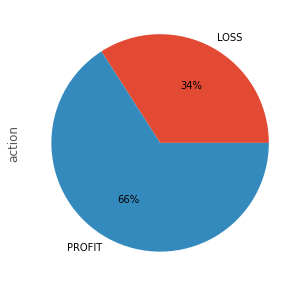

In [423]:
df_sim[df_sim['action'].isin(['PROFIT', 'LOSS'])]['action'].str.get_dummies().sum().plot(
    kind='pie', label='action', autopct='%1.0f%%', figsize=[5, 5])

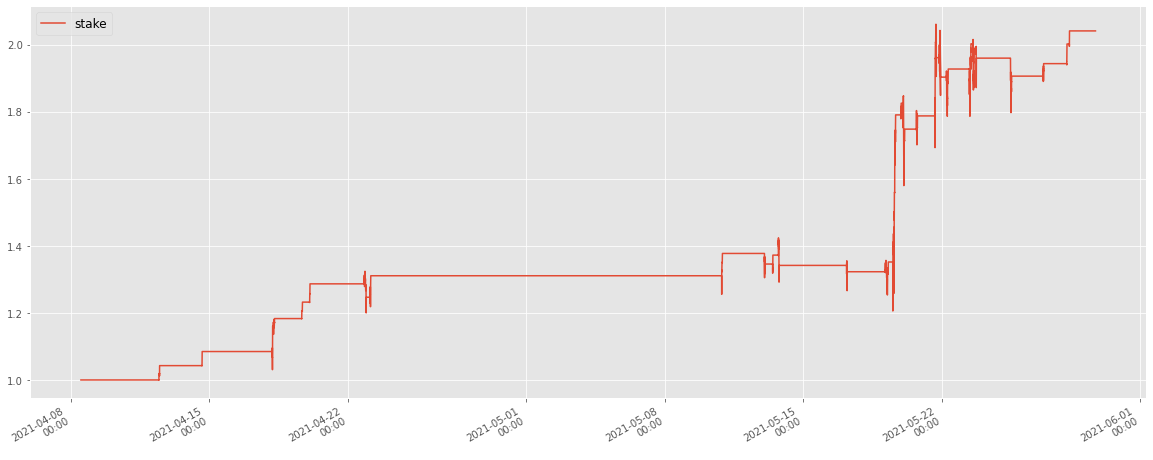

In [388]:
plot(plt.plot, df_sim, ['stake'])